## Predicting Marathi Bigg Boss () Season 3 Winner

## Dataset https://www.kaggle.com/thirumani/bigg-boss-india-hindi-telugu-tamil-kannada


In [1]:
import datetime
print("Notebook was last executed on:", datetime.date.today().strftime("%Y-%b-%d"))

### Importing Required Python Libraries

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
import seaborn as sns
from babel.numbers import format_currency

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix

### Check and import dataset

In [3]:
! ls -l /kaggle/input/bigg-boss-india-hindi-telugu-tamil-kannada/Bigg_Boss_India.csv
bigg_boss = pd.read_csv('/kaggle/input/bigg-boss-india-hindi-telugu-tamil-kannada/Bigg_Boss_India.csv', encoding = "ISO-8859-1")

nRow, nCol = bigg_boss.shape
print(f'\nThere are {nRow} rows and {nCol} columns in the dataset')

## Exploratory Data Analysis (EDA)

In [4]:
bigg_boss.head(5)

In [5]:
bigg_boss.tail(10).T

In [6]:
bigg_boss.sample(10)

In [7]:
bigg_boss.info()

In [8]:
bigg_boss.describe()

In [9]:
bigg_boss['Season Start Date'] = pd.to_datetime(bigg_boss['Season Start Date'])
bigg_boss['Season End Date'] = pd.to_datetime(bigg_boss['Season End Date'])
bigg_boss['Entry Date'] = pd.to_datetime(bigg_boss['Entry Date'])
bigg_boss['Elimination Date'] = pd.to_datetime(bigg_boss['Elimination Date'])

In [10]:
bigg_boss['Finalist'] = bigg_boss['Finalist'].astype(pd.Int32Dtype())
bigg_boss['Elimination Week Number'] = bigg_boss['Elimination Week Number'].astype(pd.Int32Dtype())
bigg_boss['Number of Evictions Faced'] = bigg_boss['Number of Evictions Faced'].astype(pd.Int32Dtype())
bigg_boss['Number of re-entries'] = bigg_boss['Number of re-entries'].astype(pd.Int32Dtype())
bigg_boss['Number of times elected as Captain'] = bigg_boss['Number of times elected as Captain'].astype(pd.Int32Dtype())
bigg_boss['Social Media Popularity'] = bigg_boss['Social Media Popularity'].astype(pd.Int32Dtype())

bigg_boss['Prize Money (INR)'] = bigg_boss['Prize Money (INR)'].str.replace(',','')
bigg_boss['Prize Money (INR)'] = pd.to_numeric(bigg_boss['Prize Money (INR)'])

bigg_boss.info()

In [11]:
# Unique values in each column
for col in bigg_boss.columns:
    print("Number of unique values in", col,"-", bigg_boss[col].nunique())

In [12]:
# Number of seasons in all Indian languages
print("Total",bigg_boss.groupby('Language')['Season Number'].nunique().sum(),"seasons broadcasted")
print(bigg_boss['Winner'].sum().astype(int)+1,"seasons completed")
print(bigg_boss.loc[bigg_boss['Winner'].isnull(), :].groupby('Language')['Season Number'].nunique().sum(),"season(s) running")

## Bigg Boss Hindi has many seasons compared to other Indian languages. So, the number of housemates are more in Hindi.

In [13]:
# Number of seasons in each Indian language
print(bigg_boss.groupby('Language')['Season Number'].nunique().nlargest(10))

In [14]:
# Total number of Bigg Boss housemates
fig = plt.figure(figsize=(10,4))
ax = sns.countplot(x='Language', data=bigg_boss, order=bigg_boss['Language'].value_counts().index)
ax.set_title('Bigg Boss Series - Indian Language')
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01))

## In Bigg Boss India seasons, most of the housemates entered in first day/week

In [15]:
# Number of normal entries and wild card entries
print(bigg_boss['Wild Card'].value_counts(), "\n")
print(round(bigg_boss['Wild Card'].value_counts(normalize=True)*100).astype(str).str.replace('.0', '%'), "\n")
sns.countplot(x='Wild Card', data=bigg_boss, palette="ch:.45")

In [16]:
# Common people has many professions, so clubbing them into one category
bigg_boss['Profession'] = bigg_boss['Profession'].fillna('UNKNOWN')
bigg_boss.loc[bigg_boss['Profession'].str.contains('Commoner'),'Profession']='Commoner'

## Number of film actresses entered into the Bigg Boss houses, are more when compared to other professions 

In [17]:
# Participant's Profession
print(bigg_boss['Profession'].value_counts())
fig = plt.figure(figsize=(20,6))
sns.countplot(x='Profession', data=bigg_boss, order=bigg_boss['Profession'].value_counts().index)
plt.xticks(rotation=90)

In [18]:
# Broadcastor
fig = plt.figure(figsize=(20,5))
ax = sns.countplot(x='Broadcasted By', data=bigg_boss, palette='RdBu', order=bigg_boss['Broadcasted By'].value_counts().index)
ax.set_title('Bigg Boss Series - Indian Broadcastor & Total Number of Housemates')
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01))

In [19]:
fig = plt.figure(figsize=(15,5))
ax = sns.countplot(bigg_boss['Broadcasted By'].str.split().str.get(0), data=bigg_boss, palette='Set3', order=bigg_boss['Broadcasted By'].str.split().str.get(0).value_counts().index)
ax.set_title('BiggBoss Series - Media House')
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01))

## Salman Khan hosted most number of seasons (in Bigg Boss Hindi), Sudeep is next on the list

In [20]:
# Bigg Boss main hosts and number of seasons they hosted
bigg_boss.groupby('Host Name')['Season Number'].nunique().nlargest(25)

In [21]:
# Temporary or Guest host who hosted the week-end episodes
bigg_boss.groupby('Guest Host Name')['Season Number'].nunique().nlargest(10)

## In all Bigg Boss competetions, in languages and in all seasons, Female contestants are more

In [22]:
# Housemate's Gender
print(bigg_boss['Gender'].value_counts(), "\n")

# In percentage
print(round(bigg_boss['Gender'].value_counts(normalize=True)*100).astype(str).str.replace('.0', '%'))

### Only 5 Transgenders (LGBT) participated in all Indian languages


In [23]:
# Maximum TRP of Bigg Boss India seasons (Big Brother in India)
print("Maximum TRP",bigg_boss['Average TRP'].max(), "\n")
print(bigg_boss.loc[bigg_boss['Average TRP']==bigg_boss['Average TRP'].max()][["Language","Season Number"]].head(1).to_string(index=False))

In [24]:
# Smallest season of Indian Bigg Boss seasons
print("Smallest season",bigg_boss['Season Length'].min(), "days \n")
print(bigg_boss.loc[bigg_boss['Season Length']==bigg_boss['Season Length'].min()][["Language","Season Number"]].head(1).to_string(index=False))

In [25]:
# Longest season of Indian Bigg Boss seasons
print("Longest season",bigg_boss['Season Length'].max(), "days \n")
print(bigg_boss.loc[bigg_boss['Season Length']==bigg_boss['Season Length'].max()][["Language","Season Number"]].head(1).to_string(index=False))

In [26]:
print("Maximum number of contestants in one season:",bigg_boss['Number of Housemates'].max(), "\n")
print(bigg_boss.loc[bigg_boss['Number of Housemates']==bigg_boss['Number of Housemates'].max()][["Language","Season Number"]].head(1).to_string(index=False))

In [27]:
print("Maximum number of evictions faced in one season:",bigg_boss['Number of Evictions Faced'].max(), "\n")
print("\nTop 3 contestants who faced maximum number of evictions\n")
print(bigg_boss.loc[bigg_boss['Number of Evictions Faced']>=bigg_boss['Number of Evictions Faced'].max()-3][["Language","Season Number","Name","Number of Evictions Faced"]].head(3).sort_values("Number of Evictions Faced",ascending=False).to_string(index=False))

In [28]:
bigg_boss['Season Length in weeks'] = round(bigg_boss['Season Length']/7,0).astype(pd.Int32Dtype())
bigg_boss['Evictions Faced Percentage'] = round(bigg_boss['Number of Evictions Faced']/bigg_boss['Season Length in weeks']*100,0).astype(pd.Int32Dtype())
print("Maximum percentage of evictions faced in one season:",bigg_boss['Evictions Faced Percentage'].max(), "%\n")
print("\nTop 3 contestants who faced maximum percentage of evictions (they were in nominations almost every week)\n")
print(bigg_boss.loc[bigg_boss['Evictions Faced Percentage']>=bigg_boss['Evictions Faced Percentage'].max()-5][["Language","Season Number","Name","Number of Evictions Faced","Season Length in weeks","Evictions Faced Percentage"]].head(3).sort_values("Evictions Faced Percentage",ascending=False).to_string(index=False))

In [29]:
print("Maximum number of re-entries:",bigg_boss['Number of re-entries'].max(), "\n")
print(bigg_boss.loc[bigg_boss['Number of re-entries']>=bigg_boss['Number of re-entries'].max()-1][["Language","Season Number","Name","Number of re-entries"]].head(5).sort_values("Number of re-entries",ascending=False).to_string(index=False))

In [30]:
print("Maximum number of times elected as captain:",bigg_boss['Number of times elected as Captain'].max(), "\n")
print(bigg_boss.loc[bigg_boss['Number of times elected as Captain']>=bigg_boss['Number of times elected as Captain'].max()-1][["Language","Season Number","Name","Number of times elected as Captain"]].head(6).sort_values("Number of times elected as Captain",ascending=False).to_string(index=False))

In [31]:
# Many contestants entered via wild card, but few managed to go to Finale
bigg_boss.loc[(bigg_boss['Wild Card']=='Yes') & (bigg_boss['Finalist']==1), :]

## About Winners only

In [32]:
print("Total Bigg Boss season winners",bigg_boss['Winner'].sum().astype(int), "(out of",bigg_boss['Finalist'].sum(),"finalists)")
# For Malayalam Season 2 winner was not declared

In [33]:
# All BB Winners
bigg_boss.loc[bigg_boss.Winner==1]

In [34]:
# Sum of prize money won by all BB Season winners/participants, in India
print(format_currency(bigg_boss['Prize Money (INR)'].sum(), 'INR', locale='en_IN').replace(".00", ""))

# 20 crores and 21 lakh rupees

In [35]:
# Profession of BB Season Winners
bigg_boss.loc[bigg_boss.Winner==1,'Profession'].value_counts()

In [36]:
# Gender of Season title Winners
print(bigg_boss.loc[bigg_boss.Winner==1,'Gender'].value_counts(),'\n')

# In percentage
print(round(bigg_boss.loc[bigg_boss.Winner==1,'Gender'].value_counts(normalize=True)*100).astype(str).str.replace('.0', '%'))

## No wild card entry housemate won the Bigg Boss competition.

In [37]:
# Entry type of the Season Winners
bigg_boss.loc[bigg_boss.Winner==1,'Wild Card'].value_counts()

In [38]:
bigg_boss.loc[bigg_boss.Winner==1,'Season Length'].value_counts().sort_index()

# Lenght of the season - Number of Winners

In [39]:
bigg_boss.loc[bigg_boss.Winner==1,'Number of Housemates'].value_counts().sort_index()

# Number of Housemates in house - Number of Winners

In [40]:
# Number of eliminations or evictions faced by the Bigg Boss competition winners
bigg_boss.loc[bigg_boss.Winner==1,'Number of Evictions Faced'].value_counts().sort_index()

# Number of eliminations faced - Number of Winners

In [41]:
# No re-entered contestant won Bigg Boss title
bigg_boss.loc[bigg_boss.Winner==1,'Number of re-entries'].value_counts()

In [42]:
# Bigg Boss title winners number of times elected as captain
bigg_boss.loc[bigg_boss.Winner==1,'Number of times elected as Captain'].value_counts().sort_index()

# Number of times elected as Captain   - Number of winners

## BB Marathi Seasons

In [43]:
lang='Marathi'

# All Bigg Boss Marathi Participants
bigg_boss.loc[(bigg_boss['Language']==lang)]

In [44]:
# Bigg Boss Marathi Winners
bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Winner']==1), :]

In [45]:
# Bigg Boss Marathi current season participants
bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Season Number']==3), :]

In [46]:
# Bigg Boss Marathi Housemate's Gender
print(bigg_boss.loc[(bigg_boss['Language']==lang), 'Gender'].value_counts(), "\n")

In [47]:
print("\nTop 3 Marathi contestants who faced maximum number of evictions\n")
tmax=bigg_boss.loc[(bigg_boss['Language']==lang),'Number of Evictions Faced'].max()
print(bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Number of Evictions Faced']>=tmax-1)][["Season Number","Name","Number of Evictions Faced"]].head(6).sort_values("Number of Evictions Faced",ascending=False).to_string(index=False))

In [48]:
print("\nTop 3 Marathi contestants who faced maximum percentage of evictions (they were in nominations for most number of weeks)\n")
tpmax=bigg_boss.loc[(bigg_boss['Language']==lang),'Evictions Faced Percentage'].max()
print(bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Evictions Faced Percentage']>=tpmax-10)][["Season Number","Name","Number of Evictions Faced","Season Length in weeks","Evictions Faced Percentage"]].head(6).sort_values("Evictions Faced Percentage",ascending=False).to_string(index=False))

## Preparing Data for ML modelling

In [49]:
# Handling NULL values
bigg_boss.isnull().sum()

In [50]:
# Removing records where Name field is empty
bigg_boss = bigg_boss.loc[bigg_boss.Name.notnull()]
bigg_boss.reset_index(drop=True,inplace=True)

In [51]:
# Contestant might have faced at least one eviction, so filling NaN with 'Number of Evictions Faced' with 1
bigg_boss['Number of Evictions Faced'] = bigg_boss['Number of Evictions Faced'].fillna(1)

# Number of re-entries are very less, so filling NULLs in 'Number of re-entries' with 0
bigg_boss['Number of re-entries'] = bigg_boss['Number of re-entries'].fillna(0)

# Filling blank values in 'Average TRP' column with average
bigg_boss['Average TRP'] = bigg_boss['Average TRP'].fillna(bigg_boss['Average TRP'].mean())

# Filling NULLs in 'Number of times elected as Captain' with 0
bigg_boss['Number of times elected as Captain'] = bigg_boss['Number of times elected as Captain'].fillna(0)

In [52]:
bigg_boss['Season Starting Year'] = bigg_boss['Season Start Date'].dt.year.astype(pd.Int32Dtype())
bigg_boss['Season Ending Year'] = bigg_boss['Season End Date'].dt.year.astype(pd.Int32Dtype())
bigg_boss['Season Starting Quarter'] = bigg_boss['Season Start Date'].dt.quarter.astype(pd.Int32Dtype())
bigg_boss['Season Ending Quarter'] = bigg_boss['Season End Date'].dt.quarter.astype(pd.Int32Dtype())
bigg_boss.info()

In [53]:
bigg_boss.head()

In [54]:
bigg_boss.tail()

In [55]:
# Updating last week-end elimination/entries manually
#bigg_boss.iloc[485,23] = 0

In [56]:
train = bigg_boss.loc[(bigg_boss['Winner'].notnull()), :]
train.sample(10)

In [57]:
test = bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Winner'].isnull()), :]
test

# Participants who are still in current Bigg Boss Marathi season

In [58]:
BB_marathi_participant = test[['Name']]
BB_marathi_participant.reset_index(drop=True, inplace=True)
BB_marathi_participant

In [59]:
train.drop(["Name","Entry Date","Elimination Date","Season Start Date","Season End Date",], axis=1, inplace=True)
test.drop(["Name","Entry Date","Elimination Date","Season Start Date","Season End Date","Winner"], axis=1, inplace=True)

In [60]:
train.head()

In [61]:
test.head()

In [62]:
# Spread of target variable
print(train['Winner'].value_counts(normalize=True)*100)

In [63]:
# One Hot Encoding

target = train.pop('Winner')
data = pd.concat([train, test])
dummies = pd.get_dummies(data, columns=data.columns, drop_first=True, sparse=True)
train2 = dummies.iloc[:train.shape[0], :]
test = dummies.iloc[train.shape[0]:, :]

In [64]:
print(train2.shape)
print(test.shape)

In [65]:
train2.isnull().sum().sort_values(ascending=False)

In [66]:
# train2.drop(["Number of Evictions Faced_15"], axis=1, inplace=True)
# test.drop(["Number of Evictions Faced_15"], axis=1, inplace=True)

In [67]:
train2.head()

In [68]:
target.values

In [69]:
x_train, x_val, y_train, y_val = train_test_split(train2, target, test_size=0.3, random_state=2021)
print(x_train.shape, x_val.shape)

In [70]:
x_train.isnull().sum().sort_values(ascending=False)

## Machine Learning Modelling

In [71]:
def plot_confusion_matrix():
    cm = confusion_matrix(y_val, y_predicted_val).T
    cm = cm.astype('float')/cm.sum(axis=0)
    ax = sns.heatmap(cm, annot=True, cmap='Blues');
    ax.set_xlabel('True Label',size=12)
    ax.set_ylabel('Predicted Label',size=12)

In [72]:
# Logistic Regression
for c in [0.01, 1, 10, 100, 1000]:
    lr = LogisticRegression(random_state=2021, C=c).fit(x_train, y_train)
    print ("F1 score for C=%s: %s" % (c, f1_score(y_val, lr.predict(x_val), average='weighted')*100))

In [73]:
logi = LogisticRegression(random_state=2021, C=100).fit(x_train, y_train)
logi

In [74]:
predicted_val_logi = logi.predict_proba(x_val)[:, 1]
y_predicted_val = (predicted_val_logi > 0.3).astype("int").ravel()
print('F1 Score -',f1_score(y_val, y_predicted_val, average='weighted')*100)
print('Accuracy Score -',accuracy_score(y_val, y_predicted_val)*100)

In [75]:
# Confusion Matrix
plot_confusion_matrix()

# TP 0.99 TN 0.91

In [76]:
predicted_val_logi = logi.predict_proba(test)[:, 1]
winner_lg = pd.concat([BB_marathi_participant, pd.DataFrame(predicted_val_logi, columns=['Predicted_Winner'])],axis=1)
winner_lg.sort_values('Predicted_Winner', ascending=False)

## Predicted Winner for Bigg Boss Marathi Season 3, as per Logistic Regression

In [77]:
# Predicted Winner for Bigg Boss Marathi Season 3, as per LogisticRegression
#winner_lg.iloc[np.argwhere(winner_lg.Predicted_Winner == np.amax(winner_lg.Predicted_Winner)).flatten().tolist()]

In [78]:
# RandomForest
rf = RandomForestClassifier(n_estimators=2000, random_state=2021).fit(x_train, y_train)
rf

In [79]:
predicted_val_rf = rf.predict_proba(x_val)[:, 1]
y_predicted_val = (predicted_val_rf > 0.3).astype("int").ravel()
print('F1 Score -',f1_score(y_val, y_predicted_val, average='weighted')*100)
print('Accuracy Score -',accuracy_score(y_val, y_predicted_val)*100)

# n_estimators=500 accuracy 98.5
# n_estimators=1000 accuracy 99.00

In [80]:
# Confusion Matrix
plot_confusion_matrix()

# TP 1 TN 0.83

In [81]:
predicted_val_rf = rf.predict_proba(test)[:,1]
winner_rf = pd.concat([BB_marathi_participant, pd.DataFrame(predicted_val_rf, columns=['Predicted_Winner'])],axis=1)
winner_rf.sort_values('Predicted_Winner', ascending=False)

## Predicted Winner for Bigg Boss Marathi Season 3, as per Random Forest

In [82]:
# Predicted Winner for Bigg Boss Marathi Season 3, as per RandomForest
#winner_rf.iloc[np.argwhere(winner_rf.Predicted_Winner == np.amax(winner_rf.Predicted_Winner)).flatten().tolist()]

## Machine Learning (ML) models to predict Indian BiggBoss (Big Brother) season Winners

## Hindi Bigg Boss Season15
## https://www.kaggle.com/thirumani/predicting-bigg-boss-hindi-season-15-winner

## Kannada Bigg Boss Season8
## https://www.kaggle.com/thirumani/predicting-bigg-boss-kannada-season-8-winner

## Telugu Bigg Boss Season5
## https://www.kaggle.com/thirumani/predicting-bigg-boss-telugu-season-5-winner

## Tamil Bigg Boss Season5
## https://www.kaggle.com/thirumani/predicting-bigg-boss-tamil-season-5-winner

## Malayalam Bigg Boss Season3
## https://www.kaggle.com/thirumani/predicting-bigg-boss-malayalam-season-3-winner

In [83]:
from wordcloud import WordCloud
text = " BiggBoss ".join(cat for cat in bigg_boss['Language'])
wordcloud = WordCloud(width = 3000, height = 2000, background_color='white', colormap='Set3', collocations=False, random_state=2021).generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

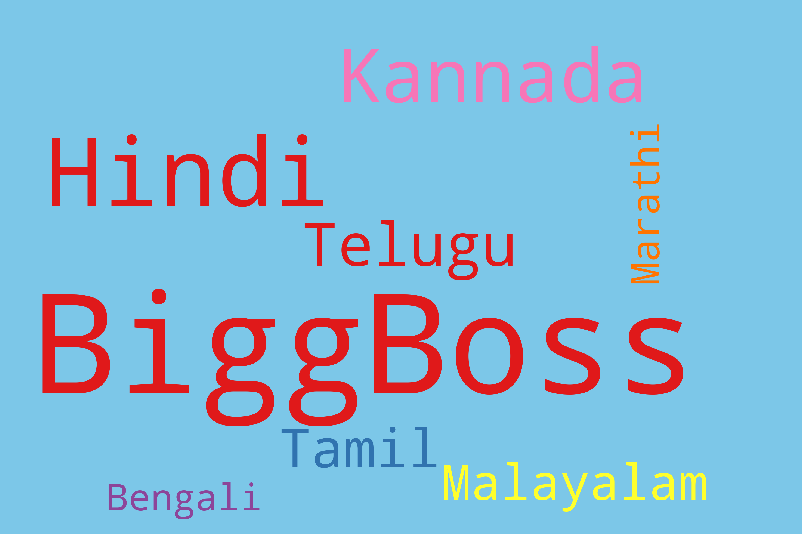